<a href="https://colab.research.google.com/github/dssikdar/ASDRP_Quantum_ML-/blob/Quantum_Conv/QCNN_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Todo**
---
> 1. Make all the Conv Layers functions <-- did this
> 2. 2x2 inputs and 4x4 inputs <-- will consider
> 3. Adam Optimizer <-- not important right now
> 4. 1.6 in tutorial <-- Monday
> 5. 1.7 in tutorial <-- Wednesday

**Installation of Necessary Modules**
1.   Tensorflow==2.4.1
2.   Tensorflow-Quantum
3.   Sympy
4.   Numpy
5.   Google Cirq
6.   Pennylane (Just in Case)



In [1]:
!pip install -q tensorflow==2.4.1 tensorflow-quantum
!pip install cirq sympy numpy pennylane

     |████████████████████████████████| 394.3 MB 12 kB/s 
     |████████████████████████████████| 7.8 MB 40.4 MB/s 
     |████████████████████████████████| 2.9 MB 45.5 MB/s 
     |████████████████████████████████| 3.8 MB 29.1 MB/s 
     |████████████████████████████████| 462 kB 33.5 MB/s 
     |████████████████████████████████| 5.6 MB 31.3 MB/s 
     |████████████████████████████████| 100 kB 9.3 MB/s 
     |████████████████████████████████| 90 kB 10.1 MB/s 
     |████████████████████████████████| 1.3 MB 42.9 MB/s 
     |████████████████████████████████| 90 kB 9.1 MB/s 
     |████████████████████████████████| 380 kB 57.9 MB/s 
     |████████████████████████████████| 1.5 MB 33.0 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 93 kB 1.1 MB/s 
     |████████████████████████████████| 93 kB 1.2 MB/s 
     |████████████████████████████████| 92 kB 1.1 MB/s 
     |██████████████████████

**Importing Modules**


1.   Matplotlib.pyplot as plt
2.   SVGCircuit from Cirq.contrib.svg
3.   Tensorflow as tf and Tensorflow_Quantum as tfq
4.   Google Cirq for writing the circuit
5.   Sympy as sp
6.   Numpy as np from Pennylane
7.   Pennylane as qml
8.   Itertools for efficient iteration
9.   Math for doing math



In [2]:
#%tb #full traceback for errors
%matplotlib inline
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
import cirq
from cirq.contrib.svg import SVGCircuit
import sympy as sp
import pennylane
from pennylane import numpy as np
from math import *
from itertools import *

**Function which Creates the Circuit and Qubits**

In [3]:
numOfQubits = 4

In [64]:
def createCircuit(num_qubits):
    qubits = cirq.LineQubit.range(num_qubits)
    circuit = cirq.Circuit()
    return qubits, circuit

In [65]:
qubits, vqc = createCircuit(numOfQubits)

*If you mess up run the "I messed up function"*


In [66]:
#I messed up function
#qubits, vqc = createCircuit(4)

**Cluster State PQC**
1. Hadamard all Qubit
2. CNOT each pair of qubits (0,1), (1,2) (2,3), (3,0)

In [67]:
def ClusterStatePQC(num_qubits, circuit):
    N = len(num_qubits)
    circuit.append(cirq.H(num_qubits[i]) for i in range(N))
    circuit.append(cirq.CNOT(num_qubits[j % N], num_qubits[ (j + 1) % N]) for j in range(N))
    return

In [68]:
ClusterStatePQC(qubits, vqc)

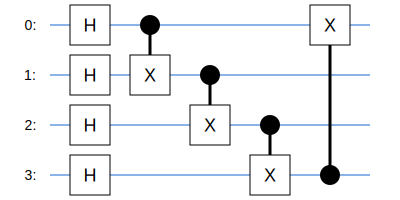

In [69]:
SVGCircuit(vqc)

**Rotation Angle Initialization before perfoming Convolution and Pooling**

In [70]:
def InitRot(numOfAngles=12*6, angle = np.pi/2):
    return np.array([angle for i in range(numOfAngles)])

In [71]:
default = InitRot()
print(default)

[1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633]


*Rotation angles subject to changes at any time*

My QConv below:

In [72]:
#U3 Gate: Three trainable parameters, for rotations along each axis
#Local Qubit = qubit on which U3 Gates is acting upon
def U3_gate_1(circuit, local, angleX, angleY, angleZ): 
    circuit.append(cirq.Rx(rads=angleX)(local))
    circuit.append(cirq.Ry(rads=angleY)(local))
    circuit.append(cirq.Rz(rads=angleZ)(local))

def U3_gate_2(circuit, local, angleX, angleY1, angleY2): 
    circuit.append(cirq.Rx(rads=angleX)(local))
    circuit.append(cirq.Ry(rads=angleY1)(local))
    circuit.append(cirq.Ry(rads=angleY2)(local))

def U3_gate_3(circuit, local, angleY, angleZ1, angleZ2): 
    circuit.append(cirq.Rz(rads=angleZ1)(local))
    circuit.append(cirq.Ry(rads=angleY)(local))
    circuit.append(cirq.Rz(rads=angleZ2)(local))

In [73]:
#Controlled version of U3 gate
#Target Qubit
#Control Qubit
def CU3_gate_1(circuit, target, control, angleX, angleY, angleZ):
    circuit.append((cirq.Rx(rads=angleX)(target)).controlled_by(control))
    circuit.append((cirq.Ry(rads=angleY)(target)).controlled_by(control))
    circuit.append((cirq.Rz(rads=angleZ)(target)).controlled_by(control))

def CU3_gate_2(circuit, target, control, angleX, angleY, angleZ):
    circuit.append((cirq.Rx(rads=angleX)(target)).controlled_by(control))
    circuit.append((cirq.Ry(rads=angleY)(target)).controlled_by(control))
    circuit.append((cirq.Rz(rads=angleZ)(target)).controlled_by(control))

def CU3_gate_3(circuit, target, control, angleX, angleY, angleZ):
    circuit.append((cirq.Rx(rads=angleX)(target)).controlled_by(control))
    circuit.append((cirq.Ry(rads=angleY)(target)).controlled_by(control))
    circuit.append((cirq.Rz(rads=angleZ)(target)).controlled_by(control))

In [74]:
def QConv(num_Qubits, circuit, layerNum, params):
    inputSize = len(num_Qubits)
    layerID = "layer"+str(layerNum)
    multiplier = 1
    for q in range(inputSize):
        if q%2==0:
            if inputSize < numOfQubits: 
                multiplier = inputSize
            U3_gate_1(circuit, num_Qubits[q], params[layerID]["angleX"][layerNum-1*multiplier], params[layerID]["angleY"][layerNum-1*multiplier], params[layerID]["angleZ"][layerNum-1*multiplier])
        else:
            CU3_gate_1(circuit, num_Qubits[q], num_Qubits[q-1*multiplier], params[layerID]["angleX"][layerNum-1*multiplier], params[layerID]["angleY"][layerNum-1*multiplier], params[layerID]["angleZ"][layerNum-1*multiplier])

def QPool(num_Qubits, circuit, final=False):
    inputSize = len(num_Qubits)
    for q in range(inputSize):
        if q%2==0:
            circuit.append(cirq.X(num_Qubits[q]))
            circuit.append((cirq.Z(num_Qubits[q+1]).controlled_by(num_Qubits[q])))
            circuit.append(cirq.X(num_Qubits[q]))
    if final: 
        circuit += cirq.measure(qubits[0], key='Measurement')

In [75]:
defVal = 0
params = {"layer1" : {"angleX" : [defVal], "angleY" : [defVal], "angleZ" : [defVal]}, 
          "layer2" : {"angleX" : [defVal], "angleY" : [defVal], "angleZ" : [defVal]}}

In [76]:
QConv(qubits, vqc, 1, params)
QPool(qubits, vqc)
QConv([qubits[0], qubits[2]], vqc, 2, params)
QPool([qubits[0], qubits[2]], vqc, True)
#SVGCircuit(vqc)
print(vqc)

                      ┌──────┐
0: ───H───@────────────X─────────Rx(0)───Ry(0)───Rz(0)───@───────@───────@───────X───@───X────────Rx(0)────Ry(0)────Rz(0)───X───@───X───M('Measurement')───
          │            │                                 │       │       │           │                                          │
1: ───H───X───@────────┼─────────────────────────────────Rx(0)───Ry(0)───Rz(0)───────Z──────────────────────────────────────────┼──────────────────────────
              │        │                                                                                                        │
2: ───H───────X───@────┼Rx(0)────Ry(0)───Rz(0)───@───────@───────@───────X───────@───X───@Rx(0)───@Ry(0)───@Rz(0)───────────────Z──────────────────────────
                  │    │                         │       │       │               │
3: ───H───────────X────@─────────────────────────Rx(0)───Ry(0)───Rz(0)───────────Z─────────────────────────────────────────────────────────────────────────
  

In [ ]:
#Try lists with Nonetype object -- works
lst = [None, None, 5]
print(lst)

[None, None, 5]


**Quantum Convolution Layer 1**.  
*Consists of RY gates with fixed angle of rotation (non-trainable) and CNOT pattern as in the PQC* 

In [ ]:
#fixed rotation angles for these gates
#subject to changes at any time
def QConvLayer1(num_qubits, circuit): 
    N = len(num_qubits)
    for i in range(N):
        circuit.append(cirq.Ry(rads=np.pi)(num_qubits[i]))
    for j in range(N):
        circuit.append(cirq.CNOT(num_qubits[j % N], num_qubits[ (j + 1) % N]))
    return

In [ ]:
QConvLayer1(qubits, vqc)

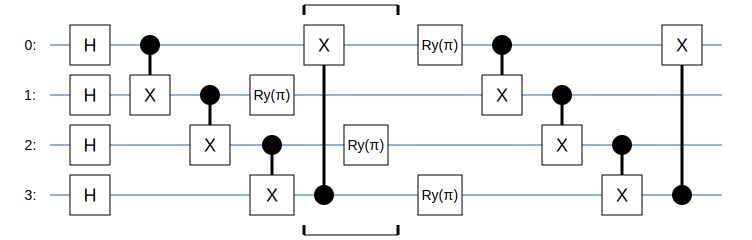

In [ ]:
SVGCircuit(vqc)

If only Google Cirq had *Barrier* to make things look good


**Quantum Convolution Layer 2**  
*Consists of U3 gates applied to each qubit and CU gates applied in the CNOT pattern*

In [18]:
#Three trainable parameters, for rotations along each axis
def U3_gate(circuit, qubit, angleX, angleY, angleZ): 
    circuit.append(cirq.Rx(rads=angleX)(qubit))
    circuit.append(cirq.Ry(rads=angleY)(qubit))
    circuit.append(cirq.Rz(rads=angleZ)(qubit))

In [19]:
#Controlled version of U3 gate
def CU_gate(circuit, qubit1, qubit2, angleX, angleY, angleZ):
    circuit.append((cirq.Rx(rads=angleX)(qubit2)).controlled_by(qubit1))
    circuit.append((cirq.Ry(rads=angleY)(qubit2)).controlled_by(qubit1))
    circuit.append((cirq.Rz(rads=angleZ)(qubit2)).controlled_by(qubit1))

In [20]:
def QConvLayer2(num_qubits, circuit, params=default):
    N = len(num_qubits)
    for i in range(N):
        U3_gate(circuit, num_qubits[i], params[i * 3], params[i * 3 + 1], params[i * 3 + 2])
    for j in range(N):
        CU_gate(circuit, num_qubits[(1 + j) % N], num_qubits[j % N],
                           params[i * 3], params[i* 3 + 1 ], params[i* 3 + 2])
        i += 3

In [21]:
QConvLayer2(qubits, vqc)

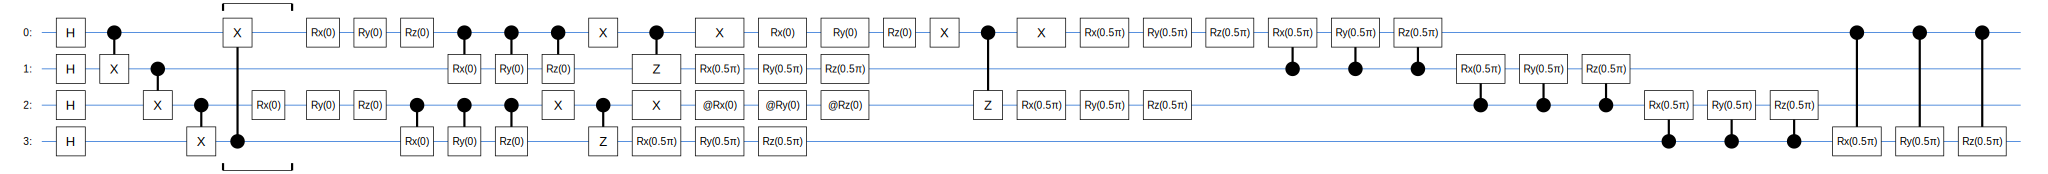

In [22]:
SVGCircuit(vqc)

**Quantum Convolution Layer 3**

In [23]:
#Adrian's QConv Layer with trainable parameters
def QConvLayer3(num_qubits, circuit, params=default[24:]):
    N = len(num_qubits)
    for i in range(N):
        U3_gate(circuit, num_qubits[i], params[i * 3], params[i * 3 + 1], params[i * 3 + 2])
    circuit.append(cirq.CNOT(num_qubits[0], num_qubits[1]))
    circuit.append(cirq.CNOT(num_qubits[3], num_qubits[2]))
    U3_gate(circuit, num_qubits[0], np.pi, np.pi, np.pi)
    U3_gate(circuit, num_qubits[3], np.pi/2, np.pi/2, np.pi/2)
    circuit.append(cirq.CNOT(num_qubits[0], num_qubits[1]))
    circuit.append(cirq.CNOT(num_qubits[3], num_qubits[2]))

In [24]:
QConvLayer3(qubits, vqc)

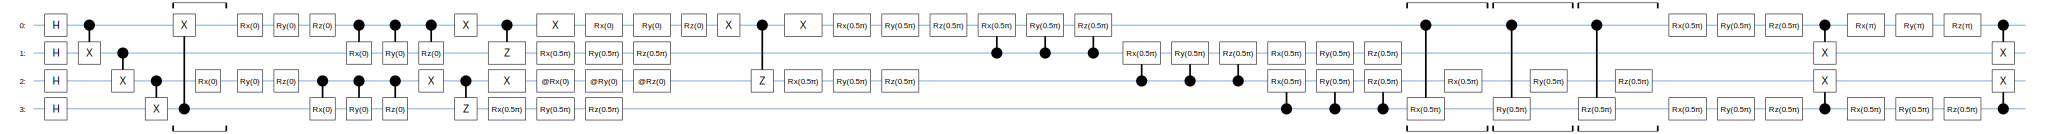

In [25]:
SVGCircuit(vqc)

**Quantum Pooling Layer 1**  

In [26]:
#TFQ Measurement on q0 (first qubit) <-- discard, we won't need this
def QPoolLayer(circuit, qubits):
  for i in range(len(qubits)):
    circuit += cirq.measure(qubits[i], key='Measurement')

In [27]:
QPoolLayer(vqc, qubits)

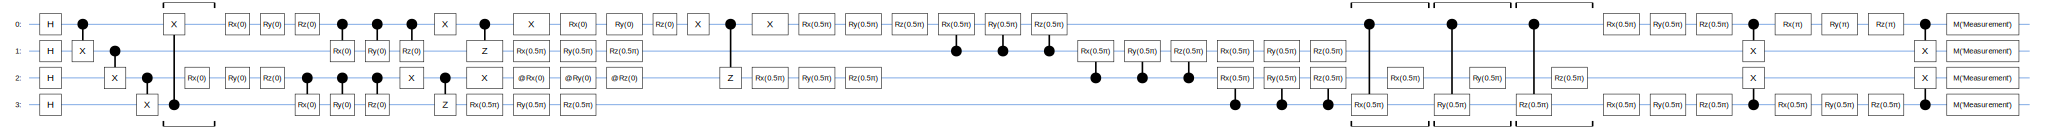

In [28]:
SVGCircuit(vqc)

**Quantum Convolution Layer 4**

In [ ]:
def QConvLayer4(num_qubits, circuit, params=default[12:]):
    N = len(num_qubits)
    U3_gate(circuit, num_qubits[0], default[0], default[1], default[2])
    for i in range(N):
        circuit.append(cirq.CNOT(num_qubits[i % N], num_qubits[(i + 1) % N]))
        CU_gate(circuit, num_qubits[i % N], num_qubits[(i + 1) % N], params[i * 3 + 3], params[i * 3 + 4], params[i * 3 + 2])

In [ ]:
QConvLayer4(qubits, vqc)

In [ ]:
#If you mess up run the stuff you need to fix
qubits, vqc = createCircuit(4)
ClusterStatePQC(qubits, vqc)
QConvLayer1(qubits, vqc)
QConvLayer2(qubits, vqc)
QConvLayer3(qubits, vqc)
vqc += cirq.measure(qubits[0], key='Measurement')
QConvLayer4(qubits, vqc)

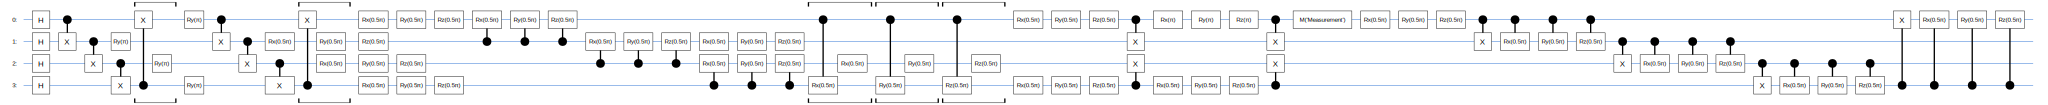

In [ ]:
SVGCircuit(vqc)

**Quantum Pooling Layer 2**  

In [ ]:
#TFQ Measurement on q1 (second qubit) and q2 (third qubit)
vqc += cirq.measure(qubits[1], key='Measurement')
vqc += cirq.measure(qubits[2],key='Measurement')

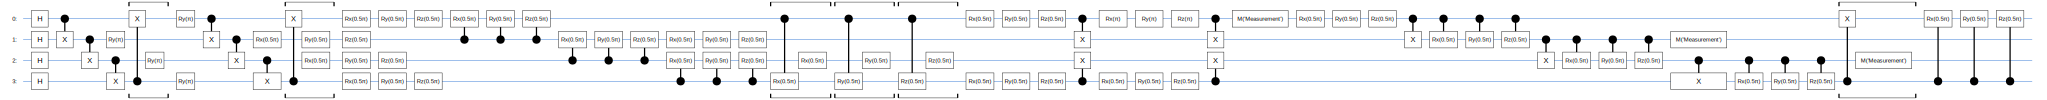

In [ ]:
SVGCircuit(vqc)

**Quantum Convolution Layer 5**

In [ ]:
def QConvLayer5(num_qubits, circuit, params=default[15:]):
    U3_gate(circuit, num_qubits[0], default[0], default[1], default[2])
    circuit.append(cirq.CNOT(num_qubits[0], num_qubits[1]))
    circuit.append(cirq.CNOT(num_qubits[2], num_qubits[3]))
    U3_gate(circuit, num_qubits[2], default[3], default[4], default[5])
    circuit.append(cirq.CNOT(num_qubits[2], num_qubits[1]))
    U3_gate(circuit, num_qubits[1], default[5], default[6], default[7])

In [ ]:
QConvLayer5(qubits, vqc)

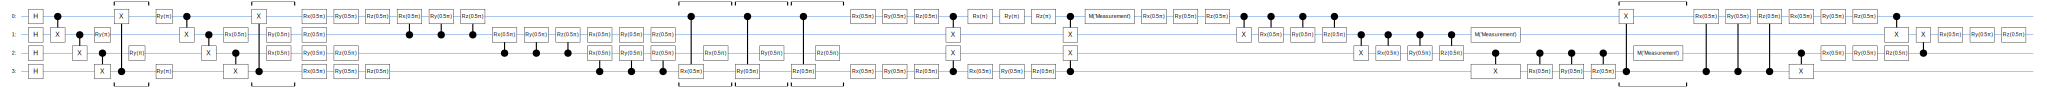

In [ ]:
SVGCircuit(vqc)

**Quantum Convolution Layer 6**  
*Same as Layer 4 but CU is CNOT*

In [ ]:
def QConvLayer6(num_qubits, circuit):
    for i in range(1, len(num_qubits)):
        circuit.append(cirq.CNOT(num_qubits[0], num_qubits[i]))
    U3_gate(circuit, num_qubits[3], np.pi, np.pi/2, np.pi/4)

In [ ]:
QConvLayer6(qubits, vqc)

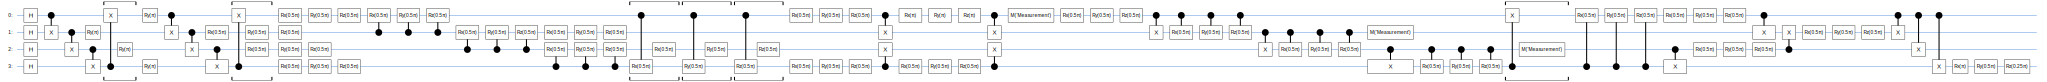

In [ ]:
SVGCircuit(vqc)

**Quantum Pooling Layer 3**  

In [ ]:
#TFQ Measurement on q3 (last qubit)
vqc += cirq.measure(qubits[3], key='Measurement')

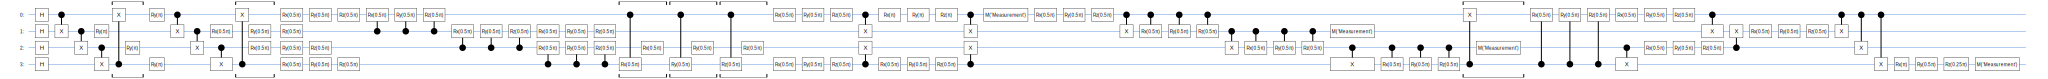

In [ ]:
SVGCircuit(vqc)

**Adam Optimzer**

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=0.01, amsgrad=False, name='Adam the optimzer')

In [ ]:
help(tf.keras.optimizers.Adam)

Help on class Adam in module tensorflow.python.keras.optimizer_v2.adam:

class Adam(tensorflow.python.keras.optimizer_v2.optimizer_v2.OptimizerV2)
 |  Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam', **kwargs)
 |  
 |  Optimizer that implements the Adam algorithm.
 |  
 |  Adam optimization is a stochastic gradient descent method that is based on
 |  adaptive estimation of first-order and second-order moments.
 |  
 |  According to
 |  [Kingma et al., 2014](http://arxiv.org/abs/1412.6980),
 |  the method is "*computationally
 |  efficient, has little memory requirement, invariant to diagonal rescaling of
 |  gradients, and is well suited for problems that are large in terms of
 |  data/parameters*".
 |  
 |  Args:
 |    learning_rate: A `Tensor`, floating point value, or a schedule that is a
 |      `tf.keras.optimizers.schedules.LearningRateSchedule`, or a callable
 |      that takes no arguments and returns the actual value to use, The
 |

**Todo**  
1. Learn about Adam optimizer
2. Implement the Adam optimzer

In [ ]:
class QCNN():
    def __init__(self):
        self.numQubits = 4
        self.name = "QCNN"
        self.numConvLayers = 6
        self.numPoolLayers = 3
    def getInfo(self):
        print(self.name, "\n", "Conv Layers:", self.numConvLayers, "\n", "Pool Layers:", self.numPoolLayers)
    def makeCircuit(self):
        qubits, circuit = createCircuit(self.numQubits)
        return qubits, circuit

In [ ]:
vqc = QCNN()
vqc.getInfo()
vqc

QCNN 
 Conv Layers: 6 
 Pool Layers: 3
